## Import Libs

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

In [2]:

# 1. Calculate average CI per sector
def calculate_average_ci(df, group_by="sector"):
    if group_by=="sector":
        return pd.DataFrame(df.groupby(
            "company's sector"
        )['carbon intensity'].mean()).round(2).sort_values(by='carbon intensity', ascending=False)
    elif group_by=='country':
        return pd.DataFrame(df.groupby(
            'country (where company is incorporated)'
            )['carbon intensity'].mean()).round(2).sort_values(by='carbon intensity', ascending=False)
    elif group_by=='stream':
        return pd.DataFrame(df.groupby('company\'s sector')[
        ['upstream co2e (fraction of total pcf)', 
         'operations co2e (fraction of total pcf)', 
         'downstream co2e (fraction of total pcf)']
        ].mean()).round(2).sort_values(by="company's sector", ascending=False)
    else:
        raise ValueError("Choose 'group_by' parameter as 'sector' or 'country' or 'stream'...!!!")


# 2. Perform ANOVA to check if differences in CI among sectors are statistically significant
def perform_anova(df, by='sector'):
    if by=="sector":
        by_groups = [df[df["company's sector"] == sector]['carbon intensity'] for sector in df["company's sector"].unique()]
        f_stat, p_value = f_oneway(*by_groups)
        return f_stat, p_value
    elif by=="country":
        by_groups = [
            df[df['country (where company is incorporated)'] == country]['carbon intensity']
            for country in df['country (where company is incorporated)'].unique()
        ]
        f_stat, p_value = f_oneway(*by_groups)
        return f_stat, p_value
    elif by=="stream":
        results = {}
        for sector in df['company\'s sector'].unique():
            subset = df[df['company\'s sector'] == sector]
            f_stat, p_value = f_oneway(subset['upstream co2e (fraction of total pcf)'],
                                    subset['operations co2e (fraction of total pcf)'],
                                    subset['downstream co2e (fraction of total pcf)'],
                                    nan_policy = 'omit')
            # print(f_stat, p_value)
            results[sector] = (f_stat, p_value)
        return pd.DataFrame(results).T
    else:
        raise ValueError("Choose 'group_by' parameter as 'sector' or 'country' or 'stream'...!!!")

# 3. Visualize CI distribution per sector
def visualize_ci_distribution(df, by='sector'):
    plt.figure(figsize=(10, 6))
    if by=='sector':
        sns.boxplot(
            y="company's sector", 
            x='carbon intensity', 
            data=df
        )
        plt.title('Carbon Intensity Distribution by Sector')
        plt.ylabel('Carbon Intensity (kg CO2e/kg)')
        plt.xlabel('Sector')
        plt.tight_layout()
        plt.show()
    elif by=='country':
        sns.boxplot(
            y='country (where company is incorporated)', 
            x='carbon intensity',
            data=df
        )
        plt.title('Carbon Intensity Distribution by Country')
        plt.ylabel('Carbon Intensity (kg CO2e/kg)')
        plt.xlabel('Country')
        plt.tight_layout()
        plt.show()
    elif by=="stream":
        df_melted = df.melt(id_vars='company\'s sector', 
                            value_vars=[
                                'upstream co2e (fraction of total pcf)', 
                                'operations co2e (fraction of total pcf)', 
                                'downstream co2e (fraction of total pcf)'],
                            var_name='Value Chain Stage', value_name='Contribution')
        plt.figure(figsize=(12, 6))
        sns.barplot(y='company\'s sector', x='Contribution', hue='Value Chain Stage', data=df_melted, palette='Set2')
        plt.title('Average Carbon Intensity Contributions by Value Chain Stage Within Sectors')
        plt.ylabel('Contribution (fraction of total CI)')
        plt.xlabel('Sector')
        plt.tight_layout()
        plt.show()
    else:
        raise ValueError("Choose 'group_by' parameter as 'sector' or 'country' or 'stream'...!!!")        


# 4. Identify overlapping CI ranges
def identify_overlapping_ranges(df):
    stats = df.groupby("company's sector")['carbon intensity'].agg(['min', 'max']).reset_index()
    overlap = []
    for i, sector_a in stats.iterrows():
        for j, sector_b in stats.iterrows():
            if i >= j:
                continue
            if (
                sector_a['min'] <= sector_b['max']
                and sector_b['min'] <= sector_a['max']
            ):
                overlap.append((sector_a["company's sector"], sector_b["company's sector"]))
    return overlap

## Load data

In [3]:
df = pd.read_excel("PublicTablesForCarbonCatalogueDataDescriptor_v30Oct2021.xlsx").convert_dtypes()

# Remove '*' and convert column names to lowercase
df.columns = df.columns.str.replace('*', '', regex=False).str.lower()
numeric_columns = [
    'upstream co2e (fraction of total pcf)', 
    'operations co2e (fraction of total pcf)', 
    'downstream co2e (fraction of total pcf)'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.head()

,pcf-id,year of reporting,stage-level co2e available,product name (and functional unit),product detail,company,country (where company is incorporated),company's gics industry group,company's gics industry,company's sector,...,relative change in pcf vs previous,company-reported reason for change,change reason category,%upstream estimated from %operations,upstream co2e (fraction of total pcf),operations co2e (fraction of total pcf),downstream co2e (fraction of total pcf),transport co2e (fraction of total pcf),endoflife co2e (fraction of total pcf),adjustments to raw data (if any)
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,...,(not reported by company),N/a,N/a (no %change reported),No,0.5750,0.3000,0.1250,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,...,(not reported by company),N/a,N/a (no %change reported),No,0.5750,0.3000,0.1250,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
2,10222-1-2013,2013,Yes,Office Chair,Field not included in 2013 data,KNOLL INC,USA,Capital Goods,Building Products,Comm. equipm. & capital goods,...,(not reported by company),N/a,N/a (no previous data available),Yes,0.8063,0.1736,0.0201,(included in up/downstream but not reported se...,0,"Changed %change to zero, according to field ""c..."
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,(not reported by company),N/a,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,<NA>
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,(not reported by company),N/a,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,<NA>


## EDA

## Question-1:

##### 1.1 Are there significant differences in average CI among sectors?

- Yes, sectors typically show significant differences in average Carbon Intensity (CI) due to varying production processes, raw material usage, and value chain contributions.

- Method: Perform an Analysis of Variance (ANOVA) to check if sector means differ significantly.

In [4]:
# Modular Execution
# 1. Calculate average CI
avg_ci = calculate_average_ci(df)
avg_ci

,carbon intensity
company's sector,
Comm. equipm. & capital goods,106.04
"Computer, IT & telecom",75.29
Automobiles & components,21.6
"Home durables, textiles, & equipment",13.28
Chemicals,5.17
Food & Beverage,5.09
Packaging for consumer goods,1.28
Construction & commercial materials,1.18


##### The p-value (<0.05) indicates significant differences in carbon intensity among sectors.

In [5]:
# 2. Perform ANOVA
f_stat, p_value = perform_anova(df)
print(f"f_stat:{f_stat} , p_value: {p_value}")

f_stat:26.818165245662108 , p_value: 2.2201664774717847e-33


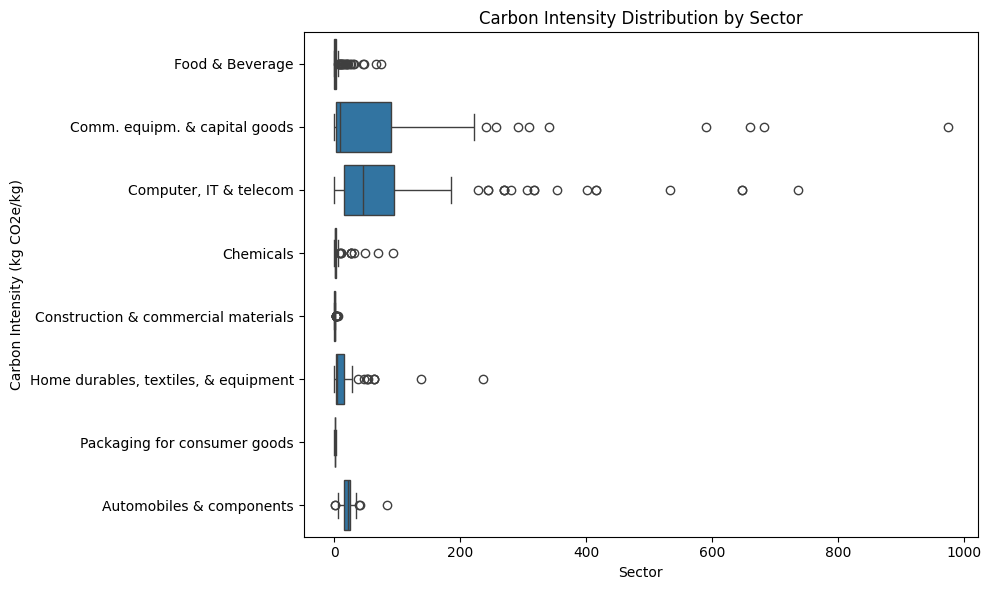

In [6]:
# 3. Visualize
visualize_ci_distribution(df)

#### 1.2 Which sectors differ significantly in their average CI?

##### Initial Insights (See Below Code)

- Sectors with High CI:

    - Comm. equipm. & capital goods (106.04): Extremely high due to the production complexity, heavy equipment, and operational energy use.
    - Computer, IT & telecom (75.29): High downstream CI from energy-intensive product usage (e.g., printers, servers).
- Sectors with Moderate CI:

    - Automobiles & components (21.60): Significant emissions from upstream material production and operational energy during use.
    - Home durables, textiles, & equipment (13.28): Emissions primarily from raw material processing and textile manufacturing.

- Sectors with Low CI:

    - Construction & commercial materials (1.18): Likely reflects efficiencies in large-scale, bulk production.
    - Packaging for consumer goods (1.28): Typically lighter-weight products with fewer manufacturing stages.


In [7]:
#Check Stats
df.groupby("company's sector")['carbon intensity'].agg(['min', 'max']).reset_index()

,company's sector,min,max
0,Automobiles & components,0.99,84.36
1,Chemicals,0.12,94.0
2,Comm. equipm. & capital goods,0.28,973.22
3,"Computer, IT & telecom",0.12,736.5
4,Construction & commercial materials,0.21,6.51
5,Food & Beverage,0.11,74.64
6,"Home durables, textiles, & equipment",0.4,235.91
7,Packaging for consumer goods,0.23,2.72


#### 1.3 Are there any sectors with overlapping CI ranges that make it difficult to distinguish their environmental performance?

##### Challenges in Environmental Performance Distinction:

- Wide Ranges within Sectors:
    - Sectors like Comm. Equip. & Capital Goods and Computer, IT & Telecom exhibit extreme CI variability, causing overlaps with both low-CI and high-CI sectors.

- Product Diversity:

    - Broad product categories (e.g., chemicals, capital goods) lead to overlaps as CI depends on product-specific characteristics.

- Shared Upstream Inputs:

    - Overlap between Chemicals and other sectors arises from common reliance on raw materials (e.g., fertilizers, synthetic polymers).

In [8]:
# 4. Identify Overlapping CI Ranges
overlapping_ranges = identify_overlapping_ranges(df)
overlapping_ranges

[('Automobiles & components', 'Chemicals'),
 ('Automobiles & components', 'Comm. equipm. & capital goods'),
 ('Automobiles & components', 'Computer, IT & telecom'),
 ('Automobiles & components', 'Construction & commercial materials'),
 ('Automobiles & components', 'Food & Beverage'),
 ('Automobiles & components', 'Home durables, textiles, & equipment'),
 ('Automobiles & components', 'Packaging for consumer goods'),
 ('Chemicals', 'Comm. equipm. & capital goods'),
 ('Chemicals', 'Computer, IT & telecom'),
 ('Chemicals', 'Construction & commercial materials'),
 ('Chemicals', 'Food & Beverage'),
 ('Chemicals', 'Home durables, textiles, & equipment'),
 ('Chemicals', 'Packaging for consumer goods'),
 ('Comm. equipm. & capital goods', 'Computer, IT & telecom'),
 ('Comm. equipm. & capital goods', 'Construction & commercial materials'),
 ('Comm. equipm. & capital goods', 'Food & Beverage'),
 ('Comm. equipm. & capital goods', 'Home durables, textiles, & equipment'),
 ('Comm. equipm. & capital g

##### 1.4 What could be reasons of these differences if any?

| **Sector**                         | **CI Drivers**                                                                                   |
|------------------------------------|--------------------------------------------------------------------------------------------------|
| **Automobiles & Components**       | Energy-intensive manufacturing, use of steel/aluminum, high downstream emissions.               |
| **Chemicals**                      | Dependence on fossil fuels, emissions from raw material extraction and reactions.               |
| **Comm. Equip. & Capital Goods**   | Large, complex products with energy-intensive assembly and heavy operational energy use.        |
| **Computer, IT & Telecom**         | Complex supply chains, high upstream emissions from microchip and electronics production.       |
| **Construction Materials**         | Lower CI due to local material sourcing and simpler processes.                                  |
| **Food & Beverage**                | Significant upstream emissions from agriculture, lower operational energy use.                  |
| **Packaging for Consumer Goods**   | Lightweight products with minimal operational and downstream emissions.                        |


## Question-2

#### 2.1 Are there significant differences in average carbon intensity (CI) across countries represented in the dataset?


In [9]:

avg_ci_country_full = calculate_average_ci(df, group_by = 'country')
avg_ci_country_full

,carbon intensity
country (where company is incorporated),
Canada,370.15
Brazil,106.17
France,60.86
Malaysia,58.42
USA,45.09
Japan,44.83
China,44.59
Taiwan,29.1
South Korea,22.32


#### 2.2 Which countries differ significantly in their average CI?

1. **High Carbon Intensity (CI):**
   - **Canada (370.15):** Extremely high CI, possibly due to energy-intensive industries like oil sands extraction.
   - **Brazil (106.17):** Likely influenced by deforestation or specific high-impact agricultural or mining activities.
   - **USA (45.09), China (44.59), and Japan (44.83):** High CI likely due to their industrial production and reliance on fossil fuels.

2. **Low Carbon Intensity (CI):**
   - **Colombia (0.18), Chile (0.52), Lithuania (0.36):** Very low CI values, possibly due to a combination of clean energy usage and less industrialization.

3. **Moderate CI Values:**
   - Countries like **Germany (20.76), South Korea (22.32), and Netherlands (2.71)** fall into moderate CI ranges, likely reflecting a mix of industrial efficiency and energy policies.


#### **Statistical Insight:**
The **F-statistic of 6.32** and **p-value of 2.21e-20** strongly indicate that average CI differs significantly among countries. Further pairwise comparisons (e.g., Tukey’s test) can pinpoint the exact countries with statistically significant differences.

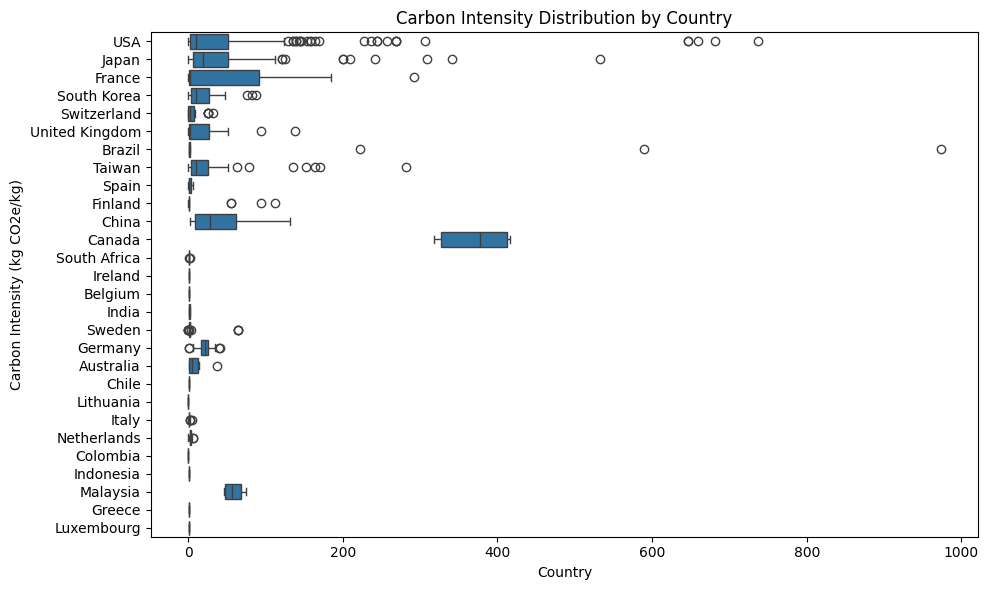

In [10]:
(f_stat_country, p_value_country) = perform_anova(df, by = "country")
visualize_ci_distribution(df, by="country")

#### 2.3 What could be the reason of these differences if any?

1. **Energy Sources:**
   - **Countries like France (60.86)**, despite reliance on nuclear power, show relatively high CI due to industrial processes.
   - **Colombia, Chile, and Sweden:** Rely heavily on hydroelectric or renewable energy sources, leading to low CI.

2. **Economic Activities:**
   - High CI in Canada and Brazil reflects heavy reliance on extractive industries (e.g., mining, agriculture, oil sands).
   - USA and China are major industrial economies, with high emissions tied to large-scale manufacturing and fossil fuel energy use.

3. **Technology and Infrastructure:**
   - Countries with access to efficient, low-carbon technology (e.g., Sweden, Germany) tend to have lower CI compared to those with outdated systems.

4. **Geographical Factors:**
   - **Transport-related emissions** in geographically large countries (e.g., Canada, USA) may be higher due to long transportation routes.

5. **Environmental Regulations:**
   - Strict regulations in Europe (e.g., Belgium, Germany) generally lead to more efficient processes, reflected in moderate CI.

## Question-3

In [11]:
avg_contributions = calculate_average_ci(df, group_by = 'stream')
avg_contributions

,upstream co2e (fraction of total pcf),operations co2e (fraction of total pcf),downstream co2e (fraction of total pcf)
company's sector,,,
Packaging for consumer goods,0.86,0.13,0.02
"Home durables, textiles, & equipment",0.49,0.12,0.38
Food & Beverage,0.53,0.28,0.19
Construction & commercial materials,0.25,0.69,0.06
"Computer, IT & telecom",0.40,0.15,0.45
Comm. equipm. & capital goods,0.33,0.07,0.60
Chemicals,0.59,0.31,0.10
Automobiles & components,0.14,0.04,0.82


#### 3.1 Interpretation of Results: ANOVA on CI Contributions Across Value Chain Portions within Sectors

1. **Significant Differences**: All sectors exhibit significant differences (p < 0.05) in contributions from upstream, operations, and downstream stages.
2. **Dominant Stages**:
   - **Upstream Dominance**: Sectors like Chemicals and Food & Beverage show higher upstream emissions due to raw material extraction and processing.
   - **Downstream Dominance**: Sectors like Automobiles & Components have significant downstream emissions from product usage.
   - **Operational Dominance**: Construction materials have high operational emissions, reflecting manufacturing intensity.
3. **Packaging for Consumer Goods**: This sector has the highest F-statistic, indicating extremely skewed contributions, likely due to minimal downstream impact compared to upstream and operations.

In [12]:
# 2. Perform ANOVA for within-sector differences
anova_results_within_sector = perform_anova(df, by='stream')
anova_results_within_sector.columns = ['F-Stat', 'P-values']
anova_results_within_sector

,F-Stat,P-values
Food & Beverage,54.970641,7.105978e-20
Comm. equipm. & capital goods,21.634163,1.471944e-08
"Computer, IT & telecom",45.939819,5.556291e-19
Chemicals,28.356784,1.009946e-10
Construction & commercial materials,669.158737,7.802478e-69
"Home durables, textiles, & equipment",24.807485,1.662503e-09
Packaging for consumer goods,2316.407406,4.491989e-66
Automobiles & components,287.166134,1.345690e-21


<Figure size 1000x600 with 0 Axes>

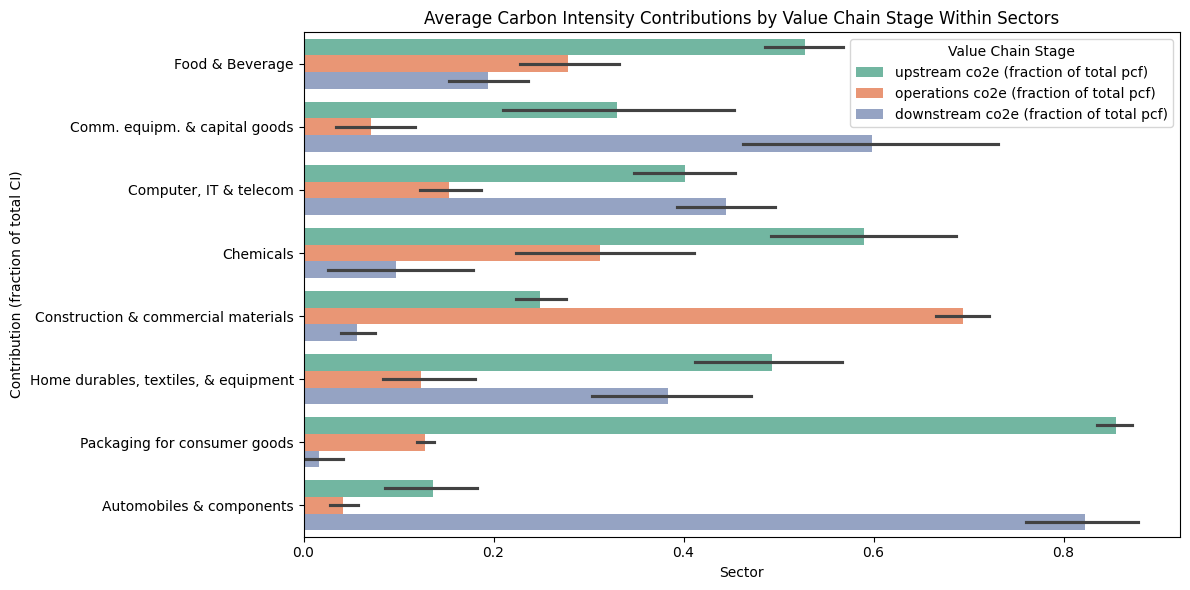

In [13]:
visualize_ci_distribution(df, by='stream')

#### 3.2 **Implications**
- **Focus on High Impact Areas**: Companies should target the dominant CI contributors (e.g., upstream for Chemicals, downstream for Automobiles).
- **Sector-Specific Strategies**: Policies to reduce emissions need to be tailored for each sector’s unique value chain structure.
- **Opportunities for Optimization**:
  - Transition to low-carbon raw materials for upstream-intensive sectors.
  - Improve energy efficiency in operations for manufacturing-heavy industries.
  - Enhance product design for reduced downstream emissions.